In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs

In [ ]:
orders = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset.xlsx', 'Orders')
returns = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset.xlsx', 'Return')
seg = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset.xlsx', 'Segmentation')
products = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Dataset.xlsx', 'Product')

In [ ]:
print(orders.info())
print(seg.info())
print(returns.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Row ID       9994 non-null   int64         
 1   Order ID     9994 non-null   object        
 2   Order Date   9994 non-null   datetime64[ns]
 3   Ship Date    9994 non-null   datetime64[ns]
 4   Ship Mode    9994 non-null   object        
 5   Customer ID  9994 non-null   object        
 6   Channel      9994 non-null   object        
 7   Postal Code  9994 non-null   int64         
 8   Product ID   9994 non-null   object        
 9   Sales        9994 non-null   float64       
 10  Quantity     9994 non-null   int64         
 11  Unit Cost    9994 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 937.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column     N

In [ ]:
sales = pd.merge(orders, returns, how = 'left', on = 'Order ID', indicator = 'Is Left')
sales = sales[sales['Is Left'] == 'left_only']
print(sales.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0     646  CA-2017-126221 2017-12-30 2018-01-05  Standard Class    CC-12430   
1     907  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
2     908  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
3     909  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
6    5092  CA-2017-156720 2017-12-30 2018-01-03  Standard Class    JM-15580   

       Channel  Postal Code       Product ID    Sales  Quantity  Unit Cost  \
0  Home Office        47201  OFF-AP-10002457  209.300         2    76.3945   
1     Consumer        10009  FUR-BO-10003441  323.136         4    77.7546   
2     Consumer        10009  TEC-PH-10004774   90.930         7    12.6003   
3     Consumer        10009  OFF-BI-10003684   52.776         3    10.9950   
6     Consumer        80538  OFF-FA-10003472    3.024         3     1.2096   

  Returned    Is Left  
0      NaN  left_only  
1      N

In [ ]:
PRESENT = dt.datetime(2017,12,31)
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
rfm= sales.groupby('Customer ID').agg({'Order Date': lambda date: (PRESENT - date.max()).days,
                                        'Order ID': lambda num: len(num),
                                        'Sales': lambda sales: sales.sum()})
rfm.columns=['recency','frequency', 'monetary']


In [ ]:
# Change the name of columns
rfm['r_score'] = pd.qcut(rfm['recency'], 5, ['5','4','3','2','1'])
rfm['f_score'] = pd.qcut(rfm['frequency'], 5, ['1','2','3','4','5'])
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, ['1','2','3','4','5'])
rfm['RFM Score'] = rfm.r_score.astype(str)+ rfm.f_score.astype(str) + rfm.m_score.astype(str)
rfm = rfm.reset_index()
print(rfm.head())

  Customer ID  recency  frequency  monetary r_score f_score m_score RFM Score
0    AA-10315      185         11  5563.560       2       3       5       235
1    AA-10375       20         15  1056.390       5       4       2       542
2    AA-10480      260         12  1790.512       2       3       3       233
3    AA-10645      483         17  5073.975       1       5       5       155
4    AB-10015      416          6   886.156       1       1       2       112


In [ ]:
print(seg.head())

              Segment                                          RFM Score
0           Champions                  555, 554, 544, 545, 454, 455, 445
1               Loyal             543, 444, 435, 355, 354, 345, 344, 335
2  Potential Loyalist  553, 551, 552, 541, 542, 533, 532, 531, 452, 4...
3       New Customers                  512, 511, 422, 421, 412, 411, 311
4           Promising  525, 524, 523, 522, 521, 515, 514, 513, 425,42...


In [ ]:

# Splitting the scores and segments into separate rows
new_data = {'Segment': [], 'RFM Score': []}

for segment, scores in zip(seg['Segment'], seg['RFM Score']):
    scores_list = scores.split(',')
    new_data['Segment'].extend([segment] * len(scores_list))
    new_data['RFM Score'].extend(scores_list)

# Creating a dataframe from the new_data dictionary
df = pd.DataFrame(new_data)
df['RFM Score'] = df['RFM Score'].str.strip()

# Printing the dataframe
print(df.head())

     Segment RFM Score
0  Champions       555
1  Champions       554
2  Champions       544
3  Champions       545
4  Champions       454


In [ ]:
customer_segments = rfm.merge(df, how= 'left', on ='RFM Score')
print(customer_segments.head())

  Customer ID  recency  frequency  monetary r_score f_score m_score RFM Score  \
0    AA-10315      185         11  5563.560       2       3       5       235   
1    AA-10375       20         15  1056.390       5       4       2       542   
2    AA-10480      260         12  1790.512       2       3       3       233   
3    AA-10645      483         17  5073.975       1       5       5       155   
4    AB-10015      416          6   886.156       1       1       2       112   

                 Segment  
0                At Risk  
1     Potential Loyalist  
2  Hibernating customers  
3       Cannot Lose Them  
4         Lost customers  


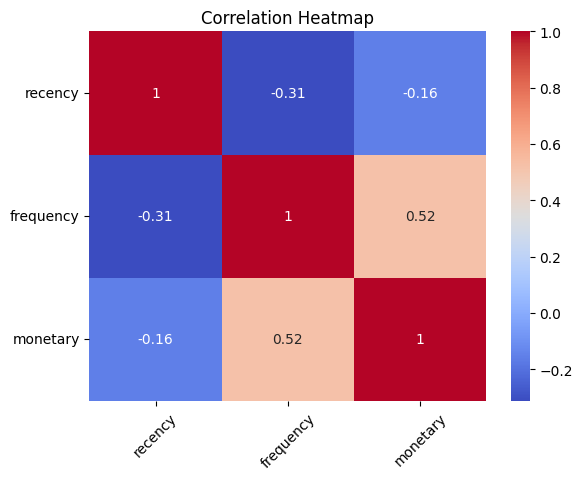

In [ ]:
# Calculate the correlation matrix
corr_matrix = customer_segments[['recency', 'frequency', 'monetary']].corr()

# Create a correlation heatmap
sns.heatmap(data=corr_matrix, annot=True, cmap='coolwarm')

# Customize the heatmap
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [ ]:
# Merge the 'customer_segments' and 'orders' DataFrames based on the 'Customer ID' column
merged_data = pd.merge(orders, customer_segments, on='Customer ID')

# Calculate the profit by subtracting the cost from the sales
merged_data['Cost']  = merged_data['Quantity'] * merged_data['Unit Cost']
merged_data['Profit'] = merged_data['Sales'] - merged_data['Cost']

# Group the merged data by segment and calculate the sum of sales, cost, and profit for each segment
segment_data = merged_data.groupby('Segment').agg({'Sales': 'sum', 'Cost': 'sum', 'Profit': 'sum'}).reset_index()

# Calculate the profit ratio (profit divided by sales) for each segment
segment_data['Profit Ratio'] = segment_data['Profit'] / segment_data['Sales']*100

print(segment_data)


                  Segment        Sales         Cost      Profit  Profit Ratio
0          About To Sleep   44838.0410   41523.2689   3314.7721      7.392767
1                 At Risk  452906.3234  370479.4687  82426.8547     18.199537
2        Cannot Lose Them  126071.0666  108181.4352  17889.6314     14.190117
3               Champions  515855.4948  445805.2581  70050.2367     13.579430
4   Hibernating customers  149882.8274  132713.9011  17168.9263     11.454899
5          Lost customers   58836.0326   57713.5434   1122.4892      1.907826
6                   Loyal  330656.5886  307785.8291  22870.7595      6.916771
7          Need Attention  217319.9639  199951.4467  17368.5172      7.992141
8           New Customers   59368.1318   52012.4458   7355.6860     12.389957
9      Potential Loyalist  197642.5536  164350.0419  33292.5117     16.844810
10              Promising  143506.8186  130085.6038  13421.2148      9.352319


In [ ]:
# Extract the year from the 'Order Date' column
merged_data['Order Year'] = merged_data['Order Date'].dt.to_period('Y')
# Group the data by year and month and segment, and calculate the total sales for each segment
year_sales = merged_data.groupby(['Order Year'])['Sales'].sum().reset_index()
print(year_sales)

  Order Year        Sales
0       2014  484124.2181
1       2015  470532.5090
2       2016  609205.5980
3       2017  733021.5172


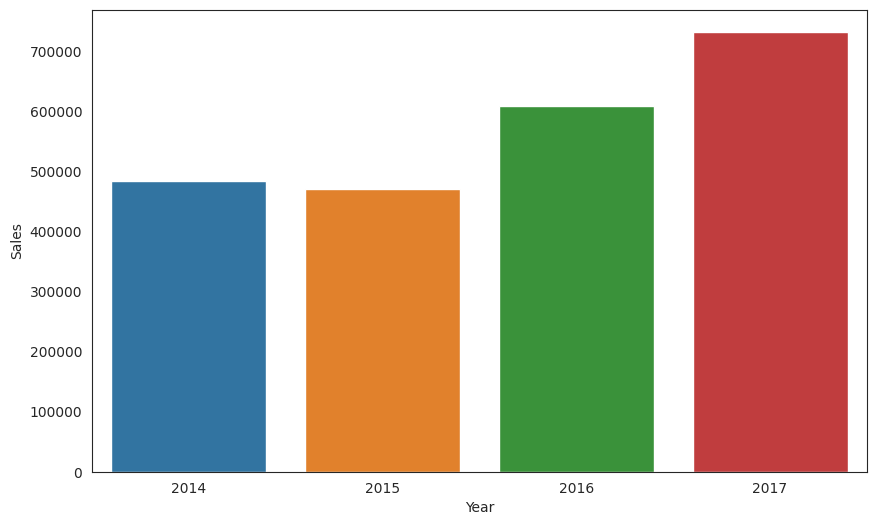

In [ ]:

# Set the figure size
plt.figure(figsize=(10, 6))
sns.set_style("white")

# Plotting the line plot for sales by customer segment over time
ax =sns.barplot(data=year_sales, x='Order Year', y='Sales')

# Set labels and title for the plot
plt.xlabel('Year')
plt.ylabel('Sales')

# Show the plot
plt.show()


In [ ]:
segment_count = customer_segments.groupby('Segment')['Customer ID'].size().reset_index()
print(segment_count)

                  Segment  Customer ID
0          About To Sleep           38
1                 At Risk           97
2        Cannot Lose Them           32
3               Champions           95
4   Hibernating customers          105
5          Lost customers           78
6                   Loyal           74
7          Need Attention           56
8           New Customers           68
9      Potential Loyalist           97
10              Promising           51


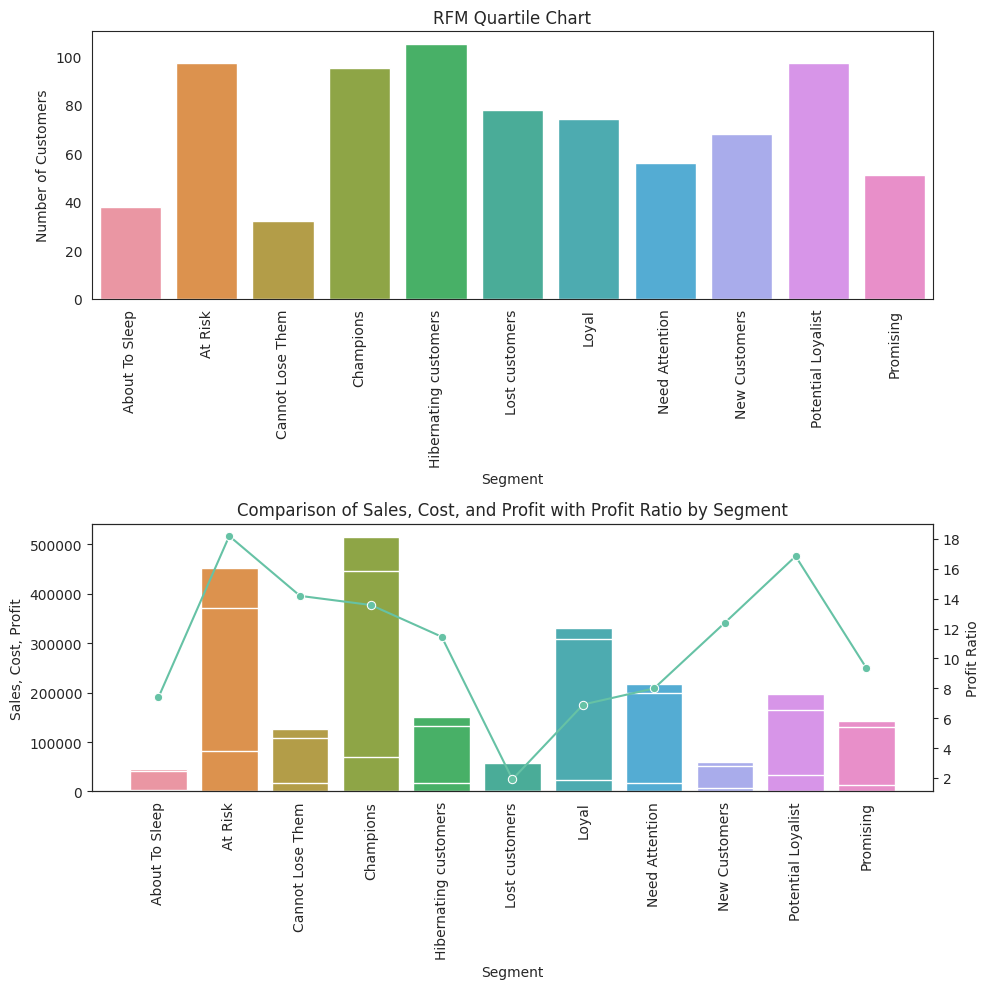

In [ ]:
# Set the figure size
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10))
sns.set_style("white")
sns.set_palette('Set2')
# Rotate x-axis labels
ax0.tick_params(axis='x', rotation=90)
ax1.tick_params(axis='x', rotation=90)

# Plotting the number of customers per segment using seaborn
sns.barplot(data=segment_count, x ='Segment', y = 'Customer ID', ax=ax0)
ax0.set_title('RFM Quartile Chart')
ax0.set_ylabel('Number of Customers')

# Plotting the bar chart for sales, cost, and profit using seaborn
sns.barplot(data=segment_data, x='Segment', y='Sales', label='Sales', ax=ax1)
sns.barplot(data=segment_data, x='Segment', y='Cost', label='Cost', ax=ax1)
sns.barplot(data=segment_data, x='Segment', y='Profit', label='Profit', ax=ax1)

# Create the second y-axis for the profit ratio line
ax2 = ax1.twinx()

# Plotting the line plot for profit ratio on the second y-axis
sns.lineplot(data=segment_data, x='Segment', y='Profit Ratio', marker = 'o',ax=ax2, sort = False, orient = 'x')
#sns.stripplot(data=segment_data, x='Segment', y='Profit Ratio', marker = 'o', ax=ax2, sort = False, hue = 'Segment', hue_order = 'Segment' )

# Set the y-axis label for the second y-axis
ax2.set_ylabel('Profit Ratio')

# Set labels and title for the first y-axis
ax1.set_ylabel('Sales, Cost, Profit')
ax1.set_title('Comparison of Sales, Cost, and Profit with Profit Ratio by Segment')

# Show the plot
plt.tight_layout()
plt.show()


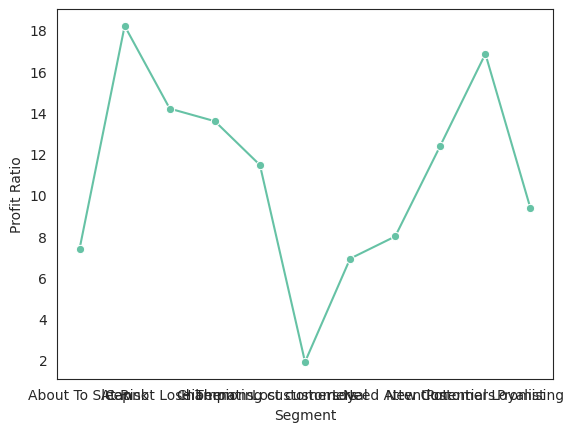

In [ ]:
sns.lineplot(data=segment_data, x='Segment', y='Profit Ratio', marker = 'o', sort = False)

# Set the y-axis label for the second y-axis

# Show the plot
plt.show()

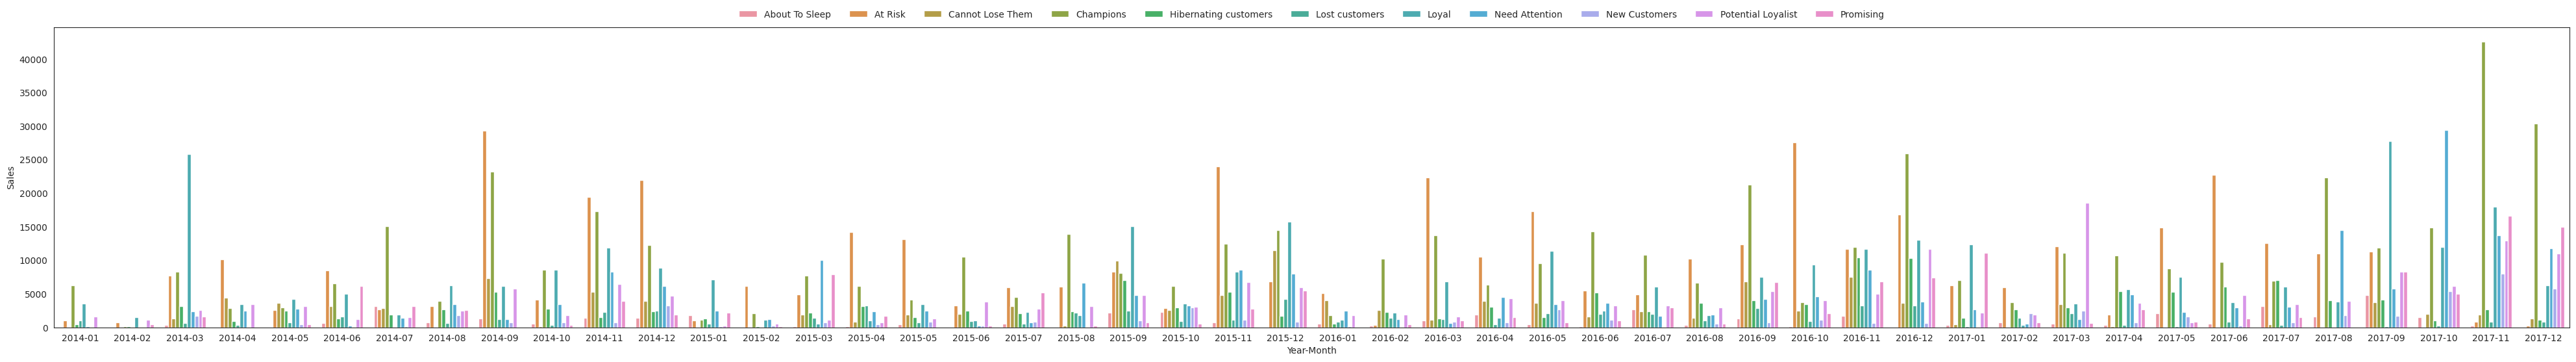

In [ ]:
# Extract the year and month from the 'Order Date' column
merged_data['Order YearMonth'] = merged_data['Order Date'].dt.to_period('M')
# Group the data by year and month and segment, and calculate the total sales for each segment
segment_sales = merged_data.groupby(['Order YearMonth', 'Segment'])['Sales'].sum().reset_index()

# Set the figure size
plt.figure(figsize=(50, 6))
sns.set_style("white")

# Plotting the line plot for sales by customer segment over time
ax =sns.barplot(data=segment_sales, x='Order YearMonth', y='Sales', hue='Segment')
sns.move_legend(ax, "lower center",bbox_to_anchor=(.5, 1), ncol=11, title=None, frameon=False,)

# Set labels and title for the plot
plt.xlabel('Year-Month')
plt.ylabel('Sales')

# Show the plot
plt.show()


In [ ]:
print(segment_data)

                  Segment        Sales         Cost      Profit  Profit Ratio
0          About To Sleep   44838.0410   41523.2689   3314.7721      7.392767
1                 At Risk  452906.3234  370479.4687  82426.8547     18.199537
2        Cannot Lose Them  126071.0666  108181.4352  17889.6314     14.190117
3               Champions  515855.4948  445805.2581  70050.2367     13.579430
4   Hibernating customers  149882.8274  132713.9011  17168.9263     11.454899
5          Lost customers   58836.0326   57713.5434   1122.4892      1.907826
6                   Loyal  330656.5886  307785.8291  22870.7595      6.916771
7          Need Attention  217319.9639  199951.4467  17368.5172      7.992141
8           New Customers   59368.1318   52012.4458   7355.6860     12.389957
9      Potential Loyalist  197642.5536  164350.0419  33292.5117     16.844810
10              Promising  143506.8186  130085.6038  13421.2148      9.352319


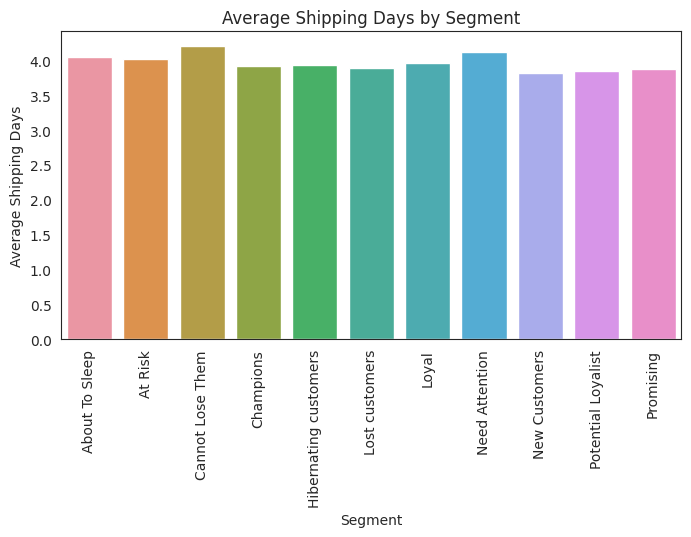

In [ ]:
# Calculate the shipping days by subtracting 'Order Date' from 'Ship Date'
merged_data['Shipping Days'] = (merged_data['Ship Date'] - merged_data['Order Date']).dt.days

# Group the data by segment and calculate the average shipping days for each segment
segment_shipping_days = merged_data.groupby('Segment')['Shipping Days'].mean().reset_index()

# Set the figure size
plt.figure(figsize = (8,4))
plt.xticks(rotation=90)

# Plotting the bar plot for average shipping days by segment
ax=sns.barplot(data=segment_shipping_days, x='Segment', y='Shipping Days')

# Set labels and title for the plot
plt.xlabel('Segment')
plt.ylabel('Average Shipping Days')
plt.title('Average Shipping Days by Segment')

# Show the plot
plt.show()

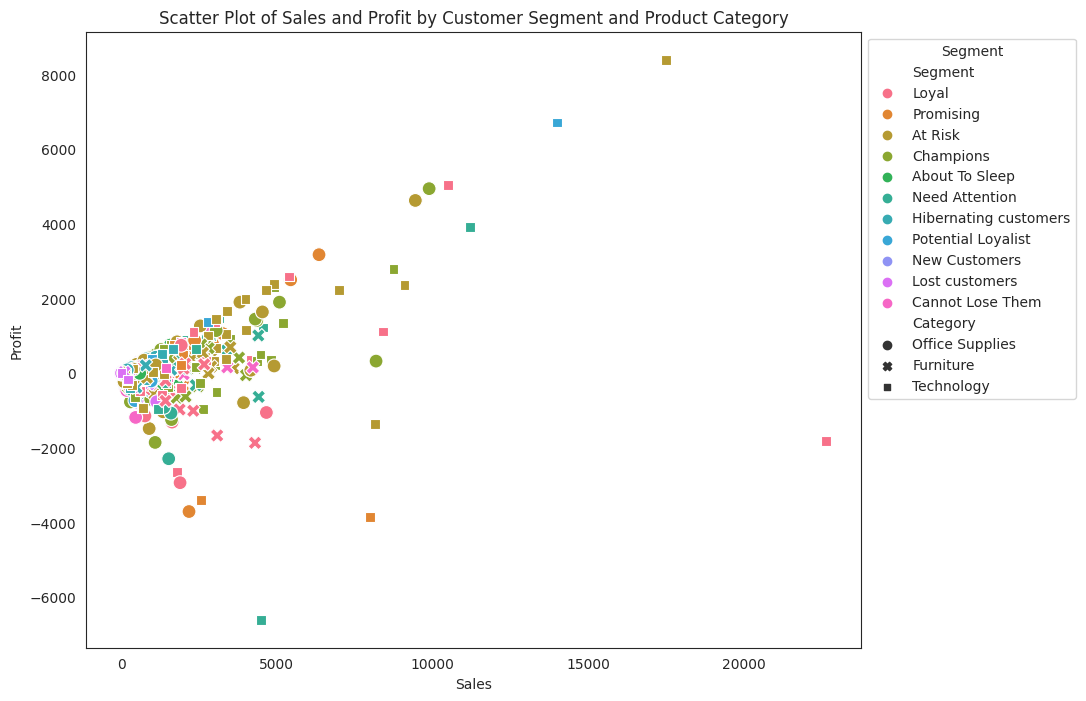

In [ ]:
# Merge the tables to combine relevant information
merged_data['Cost']  = merged_data['Quantity'] * merged_data['Unit Cost']
merged_data['Profit'] = merged_data['Sales'] - merged_data['Cost']
merged_data = merged_data.merge(products, on='Product ID')


# Set the figure size
fig, ax = plt.subplots(figsize=(10, 8))
sns.set_palette('Set2')

# Create a scatter plot to visualize sales and profit
sns.scatterplot(data=merged_data, x='Sales', y='Profit', hue='Segment', style='Category', s=100, ax=ax)

# Set labels and title for the plot
ax.set_xlabel('Sales')
ax.set_ylabel('Profit')
ax.set_title('Scatter Plot of Sales and Profit by Customer Segment and Product Category')

# Show the legend outside the plot
ax.legend(title='Segment', loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


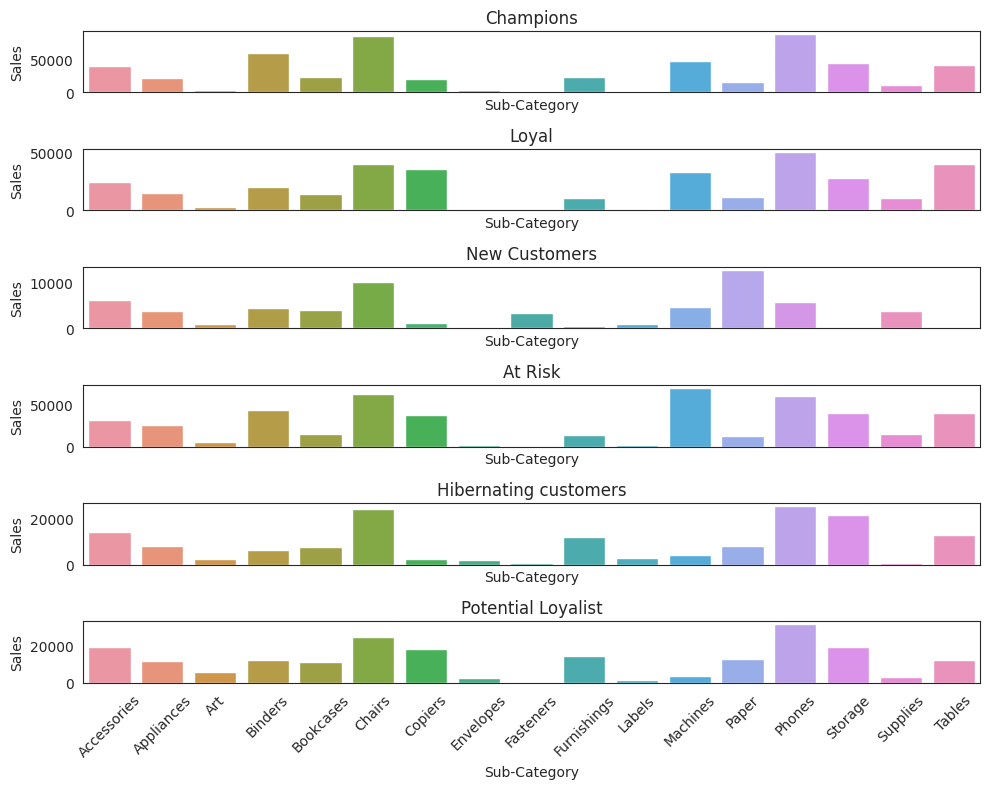

In [ ]:
# Filter the data for the desired customer segments
desired_segments = ['Champions', 'Loyal', 'New Customers', 'At Risk', 'Hibernating customers', 'Potential Loyalist']
filtered_data = customer_segments[customer_segments['Segment'].isin(desired_segments)]

# Merge the filtered data with orders and products
merged_data = filtered_data.merge(orders, on='Customer ID')
merged_data = merged_data.merge(products, on='Product ID')

# Perform a groupby operation on the desired segments and subcategories
favorite_subcategories = merged_data.groupby(['Segment', 'Sub-Category'])['Sales'].sum().reset_index()

# Set the number of rows and columns for subplots
num_rows = len(desired_segments)
num_cols = 1

# Set the figure size
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8), sharex=True)

# Iterate over the customer segments
for i, segment in enumerate(desired_segments):
    # Filter the data for the current segment
    segment_data = favorite_subcategories[favorite_subcategories['Segment'] == segment]

    # Create a bar plot for the current segment
    ax = axes[i] if num_rows > 1 else axes
    sns.barplot(data=segment_data, x='Sub-Category', y='Sales', ax=ax)
    ax.set_title(segment)
    ax.set_ylabel('Sales')
    ax.set_xlabel('Sub-Category')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Perform a groupby operation on the desired segments and subcategories
favorite_subcategories = merged_data.groupby(['Segment', 'Sub-Category'])['Sales'].sum().reset_index()
favorite_subcategories = favorite_subcategories.sort_values(by=['Segment', 'Sales'], ascending=[True, False])
favorite_subcategories = favorite_subcategories.groupby('Segment').first().reset_index()

# Print the favorite product subcategories for each segment
print(favorite_subcategories[['Segment', 'Sub-Category']])


                 Segment Sub-Category
0                At Risk     Machines
1              Champions       Phones
2  Hibernating customers       Phones
3                  Loyal       Phones
4          New Customers       Phones
5     Potential Loyalist       Phones


In [1]:
print( False not True)

SyntaxError: ignored

Insights & recommendations
https://rectangular-dinner-1ca.notion.site/Final-project-70164b84daaa48d09581f70fae780b0f?pvs=4
